---

In [4]:
! pip install  dask[dataframe] geopandas odc-stac osmnx pystac_client rioxarray xarray xarray-spatial

---

In [5]:
# Access OpenStreetMap data
import osmnx as ox

# Access satellite data
import pystac_client
import odc.stac

# Vector data handling
import geopandas as gpd

# Raster data handling
import rioxarray

# Raster analyses
import xrspatial

# Visualization
import matplotlib.pyplot as plt

## Define the Area of Interest

In [6]:
# Get polygon of Rhodes
rhodes = ox.geocode_to_gdf("Rhodes")

In [7]:
rhodes

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((27.68357 36.15271, 27.68378 36...",27.683572,35.876662,28.247628,36.458283,49986570,relation,452614,36.17253,27.919402,place,island,17,0.64943,island,Rhodes,"Rhodes, Aegean, Greece"


<Axes: >

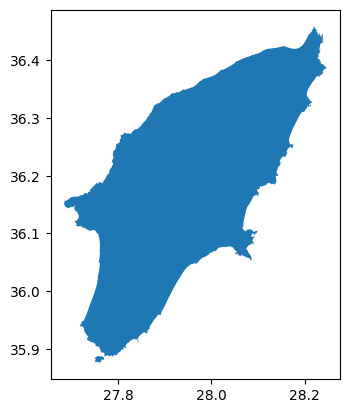

In [8]:
rhodes.plot()

In [9]:
rhodes.to_file("rhodes.gpkg")

## Search for Satellite Images

In [10]:
# Setup search client for STAC API
api_url = 'https://earth-search.aws.element84.com/v1'
client = pystac_client.Client.open(api_url)

In [11]:
# See collections with: list(client.get_collections())
collection = 'sentinel-2-c1-l2a'  # Sentinel-2, Level 2A
# Get the search geometry from the GeoDataFrame
polygon = rhodes.loc[0, 'geometry']

In [12]:
# Setup the search
search = client.search(
    collections=[collection],
    intersects=polygon,
    datetime='2023-07-01/2023-08-31', # date range
    query=['eo:cloud_cover<10'] # cloud cover less than 10%
)

In [13]:
search.matched()

64

In [14]:
items = search.item_collection()

In [15]:
# Save search results
items.save_object('rhodes_sentinel-2.json')

## Open Satellite Images

In [16]:
# Load the search results as a xarray Dataset
ds = odc.stac.load(
    items,
    groupby="solar_day", # group the images within the same day
    bands=["red", "green", "blue", "nir", "scl"],
    resolution=40, # loading resolution
    chunks={'x': 2048, 'y':  2048}, # lazy loading with Dask
    bbox=polygon.bounds,
    dtype="uint16"
)

In [17]:
print(ds)

<xarray.Dataset> Size: 522MB
Dimensions:      (y: 1626, x: 1285, time: 25)
Coordinates:
  * y            (y) float64 13kB 4.036e+06 4.035e+06 ... 3.971e+06 3.97e+06
  * x            (x) float64 10kB 5.613e+05 5.613e+05 ... 6.126e+05 6.126e+05
    spatial_ref  int32 4B 32635
  * time         (time) datetime64[ns] 200B 2023-07-01T09:10:15.805000 ... 20...
Data variables:
    red          (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    green        (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    blue         (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    nir          (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    scl          (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>


In [18]:
ds_before = ds.sel(time="2023-07-13", method="nearest")
ds_after = ds.sel(time="2023-08-27", method="nearest")

In [19]:
def rgb_img(ds):
    """
    Generate RGB raster.

    Sentiel-2 L2A images are provided in Digital Numbers (DNs).
    Convert to reflectance by dividing by 10,000. Set reflectance
    equal to one for values >= 10,000.
    """
    ds_rgb = ds[["red", "green", "blue"]].to_array()
    ds_rgb = ds_rgb.clip(max=10000)
    return ds_rgb / 10_000

rgb_before = rgb_img(ds_before)
rgb_after = rgb_img(ds_after)

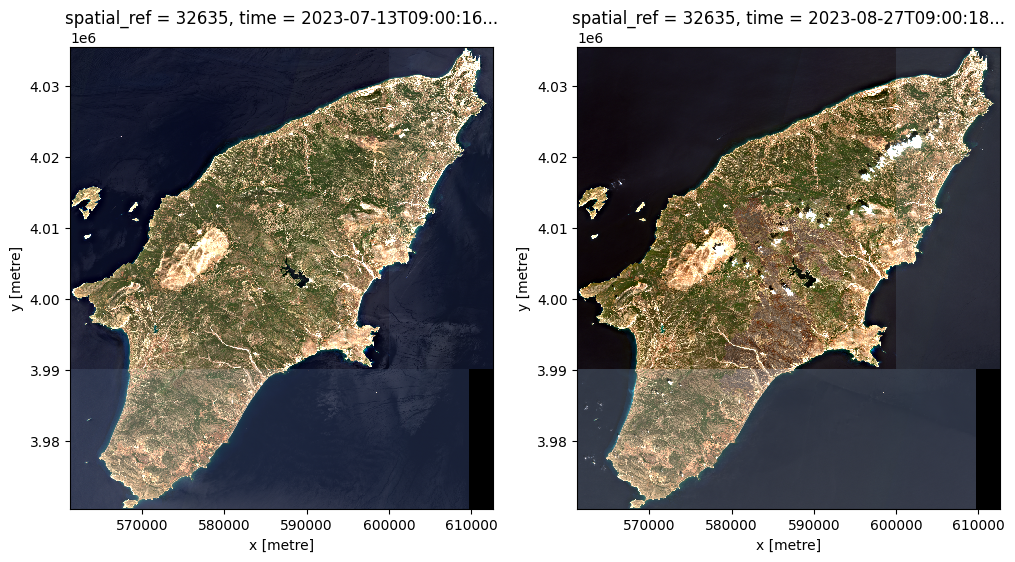

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Use "robust=True" to improve contrast
rgb_before.plot.imshow(ax=axs[0], robust=True)
rgb_after.plot.imshow(ax=axs[1], robust=True)

## Raster Calculations

* Masking water and clouds
* Calculating NDVI (difference)

In [21]:
def mask_water_and_clouds(ds):
    """
    Mask water and clouds using the Sentinel-2
    scene classification map.
    """
    mask = ds["scl"].isin([3, 6, 8, 9, 10])
    return ds.where(~mask)

In [22]:
ds_masked = mask_water_and_clouds(ds)

Normalized Difference Vegetation Index (NDVI):

$$ NDVI = \frac{NIR - red}{NIR + red}$$

In [23]:
ndvi = (
    (ds_masked["nir"] - ds_masked["red"]) /
    (ds_masked["nir"] + ds_masked["red"])
)

In [24]:
ndvi_before = ndvi.sel(time="2023-07-13", method="nearest")
ndvi_after = ndvi.sel(time="2023-08-27", method="nearest")

In [25]:
ndvi_diff = ndvi_after - ndvi_before

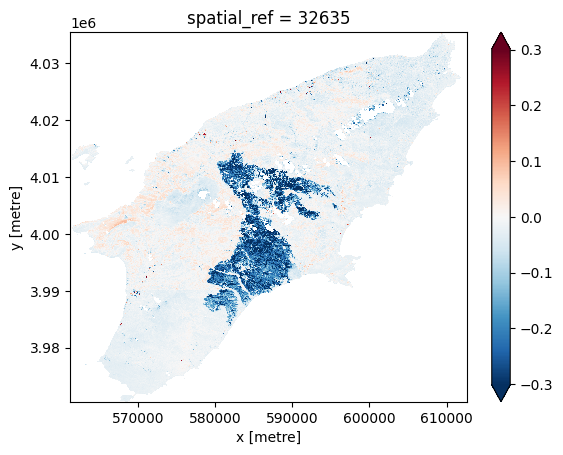

In [26]:
ndvi_diff.plot.imshow(robust=True)

If the NDVI drops significantly, we flag a vegetation damage. We use an arbitrary threshold here (0.4), for demonstration purposes.

In [27]:
burned_mask = ndvi_diff < -0.4

We visualize the burned area (in red) over the image taken after the wild fires.

In [28]:
# set 1. in red channel
rgb_after[0, :, :] = rgb_after[0, :, :].where(~burned_mask, other=1)
# set 0. in green and blue channels
rgb_after[1:3, :, :] = rgb_after[1:3, :, :].where(~burned_mask, other=0)

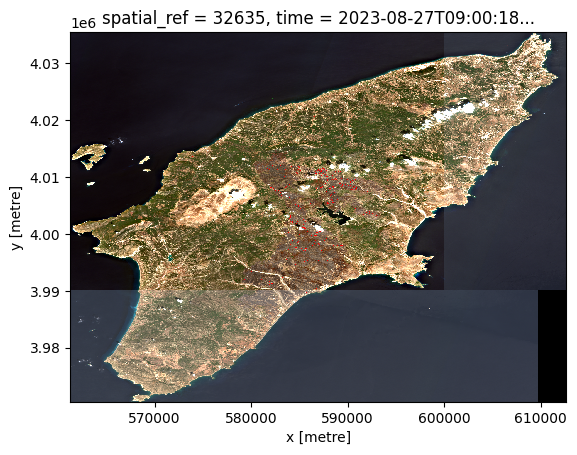

In [29]:
rgb_after.plot.imshow(robust=True)

## Spatial Analysis

* Proximity analysis: how far are the main roads from the burned area?


In [30]:
# Download road network from OSM
highways = ox.features_from_place(
    "Rhodes",
    tags={
        "highway":[
            "primary",
            "secondary",
            "tertiary",
        ]
    }
)

In [31]:
highways.head()

geometry  \
element id                                                            
way     16227449  LINESTRING (28.05782 36.11255, 28.05777 36.112...   
        23857290  LINESTRING (28.15816 36.29237, 28.15804 36.292...   
        23857299  LINESTRING (28.17677 36.28603, 28.17512 36.287...   
        23857798  LINESTRING (28.16234 36.29545, 28.16222 36.295...   
        23886864  LINESTRING (28.16264 36.29141, 28.16264 36.291...   

                    highway                       name  \
element id                                               
way     16227449  secondary           Κάλαθος - Λάρδος   
        23857290  secondary                     Αθήνας   
        23857299   tertiary  Αφάντου - Παραλία Αφάντου   
        23857798  secondary          Εθνάρχου Μακαρίου   
        23886864  secondary                     Περνού   

                                    name:el name:en source  ref lanes  lit  \
element id                                                                   
way     16227449                        NaN     NaN    NaN  NaN     1  yes   
        23857290                        NaN     NaN    NaN  NaN     2  NaN   
        23857299  Αφάντου - Παραλία Αφάντου     NaN    NaN  NaN     2  NaN   
        23857798                        NaN     NaN    NaN  NaN   NaN  NaN   
        23886864                        NaN     NaN    NaN  NaN   NaN  NaN   

                 maxspeed  ... intermittent turn:lanes:backward  \
element id                 ...                                    
way     16227449       50  ...          NaN                 NaN   
        23857290      NaN  ...          NaN                 NaN   
        23857299      NaN  ...          NaN                 NaN   
        23857798      NaN  ...          NaN                 NaN   
        23886864      NaN  ...          NaN                 NaN   

                 turn:lanes:forward lanes:backward lanes:forward  \
element id                                                         
way     16227449                NaN            NaN           NaN   
        23857290                NaN            NaN           NaN   
        23857299                NaN            NaN           NaN   
        23857798                NaN            NaN           NaN   
        23886864                NaN            NaN           NaN   

                 placement:forward placement destination destination:lang:en  \
element id                                                                     
way     16227449               NaN       NaN         NaN                 NaN   
        23857290               NaN       NaN         NaN                 NaN   
        23857299               NaN       NaN         NaN                 NaN   
        23857798               NaN       NaN         NaN                 NaN   
        23886864               NaN       NaN         NaN                 NaN   

                 check_date:lit  
element id                       
way     16227449            NaN  
        23857290            NaN  
        23857299            NaN  
        23857798            NaN  
        23886864            NaN  

[5 rows x 63 columns]

In [32]:
# compute (horizontal) distance from burned area
distance = xrspatial.proximity(burned_mask)

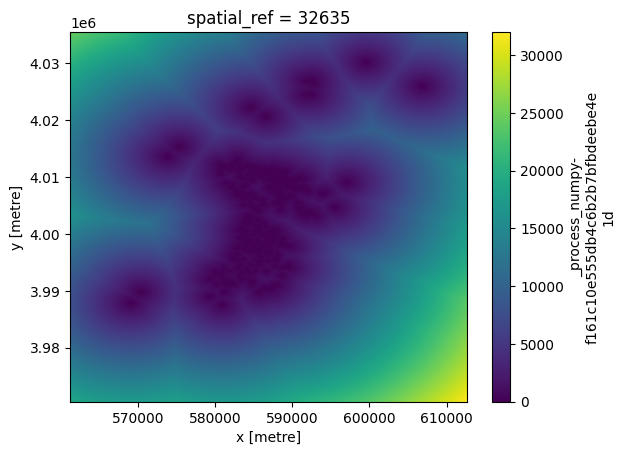

In [33]:
distance.plot.imshow()

In [34]:
highways_buffer = highways \
    .to_crs(burned_mask.rio.crs) \
    .buffer(50)  # 50m buffer around the roads

In [35]:
highways_buffer.head()

element  id      
way      16227449    POLYGON ((595245.628 3996919.334, 595242.555 3...
         23857290    POLYGON ((603734.479 4017325.585, 603733.866 4...
         23857299    POLYGON ((605499.357 4016384.271, 605481.244 4...
         23857798    POLYGON ((604268.978 4017155.49, 604267.841 40...
         23886864    POLYGON ((604331.176 4017312.025, 604327.734 4...
dtype: geometry

In [36]:
distance_clip = distance.rio.clip(highways_buffer)

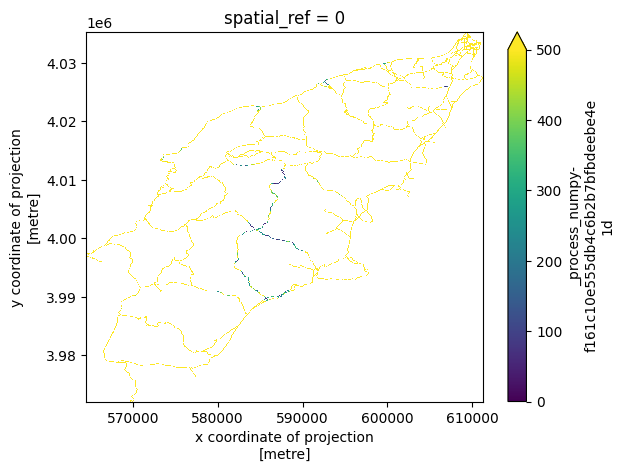

In [37]:
# Visualize roads, focusing on distances <500m from the fires
distance_clip.plot.imshow(vmax=500)